In [ ]:
install.packages('farff')
install.packages('cvTools')
install.packages('ModelMetrics')
install.packages('car')
install.packages('keras')
install.packages('caret')

library(farff) # for reading arff file
library(cvTools) # explicit creation of folds for cross-validation
library(ModelMetrics) # used for precision-recall evaluation of classifiers
library(car) # for recode function
library(ggplot2)


Loading required package: lattice

Loading required package: robustbase


Attaching package: ‘ModelMetrics’


The following object is masked from ‘package:base’:

    kappa


Loading required package: carData



## jumpstart code

In [ ]:
# optimal cutoff for predicting bad credit set as
# (cost of false negative/cost of false positive) times
# (prevalence of positive/prevalence of negative)
# (1/5)*(.3/.7) = 0.086
CUTOFF = 0.086
COSTMATRIX = matrix(c(0,5,1,0), nrow = 2, ncol = 2, byrow = TRUE)

credit = readARFF("dataset_31_credit-g.arff")
# write to comma-delimited text for review in Excel
write.csv(credit, file = "credit.csv", row.names = FALSE)

Parse with reader=readr : dataset_31_credit-g.arff

Loading required package: readr

header: 0.083000; preproc: 0.002000; data: 0.148000; postproc: 0.003000; total: 0.236000



In [ ]:
# check structure of the data frame
cat("\n\nStucture of initial credit data frame:\n")
print(str(credit))



Stucture of initial credit data frame:
'data.frame':	1000 obs. of  21 variables:
 $ checking_status       : Factor w/ 4 levels "<0","0<=X<200",..: 1 2 4 1 1 4 4 2 4 2 ...
 $ duration              : num  6 48 12 42 24 36 24 36 12 30 ...
 $ credit_history        : Factor w/ 5 levels "no credits/all paid",..: 5 3 5 3 4 3 3 3 3 5 ...
 $ purpose               : Factor w/ 11 levels "new car","used car",..: 4 4 7 3 1 7 3 2 4 1 ...
 $ credit_amount         : num  1169 5951 2096 7882 4870 ...
 $ savings_status        : Factor w/ 5 levels "<100","100<=X<500",..: 5 1 1 1 1 5 3 1 4 1 ...
 $ employment            : Factor w/ 5 levels "unemployed","<1",..: 5 3 4 4 3 3 5 3 4 1 ...
 $ installment_commitment: num  4 2 2 2 3 2 3 2 2 4 ...
 $ personal_status       : Factor w/ 5 levels "male div/sep",..: 3 2 3 3 3 3 3 3 1 4 ...
 $ other_parties         : Factor w/ 3 levels "none","co applicant",..: 1 1 1 3 1 1 1 1 1 1 ...
 $ residence_since       : num  4 2 3 4 4 4 4 2 4 2 ...
 $ property_magnitude    :

In [ ]:
# quick summary of credit data
cat("\n\nSummary of initial credit data frame:\n")
print(summary(credit))



Summary of initial credit data frame:
    checking_status    duration                           credit_history
 <0         :274    Min.   : 4.0   no credits/all paid           : 40   
 0<=X<200   :269    1st Qu.:12.0   all paid                      : 49   
 >=200      : 63    Median :18.0   existing paid                 :530   
 no checking:394    Mean   :20.9   delayed previously            : 88   
                    3rd Qu.:24.0   critical/other existing credit:293   
                    Max.   :72.0                                        
                                                                        
                purpose    credit_amount            savings_status
 radio/tv           :280   Min.   :  250   <100            :603   
 new car            :234   1st Qu.: 1366   100<=X<500      :103   
 furniture/equipment:181   Median : 2320   500<=X<1000     : 63   
 used car           :103   Mean   : 3271   >=1000          : 48   
 business           : 97   3rd Qu.: 3972 

In [ ]:
# personal_status has level "female single" with no observations
cat("\n\nProblems with personal_status, no single females:\n")
print(table(credit$personal_status))



Problems with personal_status, no single females:

      male div/sep female div/dep/mar        male single       male mar/wid 
                50                310                548                 92 
     female single 
                 0 


In [ ]:
# fix this prior to analysis
credit$personal_status = factor(as.numeric(credit$personal_status),
    levels = c(1,2,3,4), 
    labels = c("male div/sep","female div/dep/mar","male single","male mar/wid"))

cat("\n\nProblems with purpose, low- and no-frequency levels:\n")
print(table(credit$purpose))



Problems with purpose, low- and no-frequency levels:

            new car            used car furniture/equipment            radio/tv 
                234                 103                 181                 280 
 domestic appliance             repairs           education            vacation 
                 12                  22                  50                   0 
         retraining            business               other 
                  9                  97                  12 


In [ ]:
# keep first four classes: "new car", "used car", "furniture/equipment", "radio/tv"
# keep "education" and "business" with new values 
# add "retraining" to "education"
# gather all other levels into "other"
credit$purpose = recode(credit$purpose, '"new car" = "new car";
    "used car" = "used car"; 
    "furniture/equipment" = "furniture/equipment";
    "radio/tv" = "radio/tv"; 
    "education" = "education"; "retraining" = "education";
    "business" = "business"; 
    "domestic appliance" = "other"; "repairs" = "other"; "vacation" = "other"; 
    "other" = "other" ',
    levels = c("new car","used car","furniture/equipment","radio/tv", 
    "education","business","other" ))

# credit_amount is highly skewed... use log_credit_amount instead
credit$log_credit_amount = log(credit$credit_amount)    

# summary of transformed credit data
cat("\n\nSummary of revised credit data frame:\n")
print(summary(credit))



Summary of revised credit data frame:
    checking_status    duration                           credit_history
 <0         :274    Min.   : 4.0   no credits/all paid           : 40   
 0<=X<200   :269    1st Qu.:12.0   all paid                      : 49   
 >=200      : 63    Median :18.0   existing paid                 :530   
 no checking:394    Mean   :20.9   delayed previously            : 88   
                    3rd Qu.:24.0   critical/other existing credit:293   
                    Max.   :72.0                                        
                                                                        
                purpose    credit_amount            savings_status
 new car            :234   Min.   :  250   <100            :603   
 used car           :103   1st Qu.: 1366   100<=X<500      :103   
 furniture/equipment:181   Median : 2320   500<=X<1000     : 63   
 radio/tv           :280   Mean   : 3271   >=1000          : 48   
 education          : 59   3rd Qu.: 3972 

In [ ]:
# logistic regression evaluated with cross-validation
# include explanatory variables except foreign_worker
# (only 37 of 100 cases are foreign workers)
credit_model = "class ~ checking_status + duration + 
    credit_history + purpose + log_credit_amount + savings_status + 
    employment + installment_commitment + personal_status +        
    other_parties + residence_since + property_magnitude +
    age + other_payment_plans + housing + existing_credits +      
    job + num_dependents + own_telephone" 

set.seed(1)
nfolds = 5
folds = cvFolds(nrow(credit), K = nfolds) # creates list of indices

baseprecision = rep(0, nfolds)  # precision with 0 cutoff
baserecall = rep(0, nfolds)  # recall with  0 cutoff
basef1Score = rep(0, nfolds)  # f1Score with 0 cutoff
basecost = rep(0, nfolds)  # total cost with 0 cutoff
ruleprecision = rep(0, nfolds)  # precision with CUTOFF rule
rulerecall = rep(0, nfolds)  # recall with CUTOFF rule
rulef1Score = rep(0, nfolds)  # f1Score with CUTOFF rule
rulecost = rep(0, nfolds)  # total cost with CUTOFF rule

for (ifold in seq(nfolds)) {
    # cat("\n\nSUMMARY FOR IFOLD:", ifold) # checking in development
    # print(summary(credit[(folds$which == ifold),]))
    # train model on all folds except ifold
    train = credit[(folds$which != ifold), ]
    test = credit[(folds$which == ifold),]
    credit_fit = glm(credit_model, family = binomial,
        data = train)
    # evaluate on fold ifold    
    credit_predict = predict.glm(credit_fit, 
        newdata = test, type = "response") 
    baseprecision[ifold] = ppv(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5)  
    baserecall[ifold] = recall(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5) 
    basef1Score[ifold] = f1Score(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5) 
    basecost[ifold] = sum(
        confusionMatrix(as.numeric(test$class)-1,
        credit_predict) * COSTMATRIX)  
    ruleprecision[ifold] = ppv(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF)  
    rulerecall[ifold] = recall(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF) 
    rulef1Score[ifold] = f1Score(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF)
    rulecost[ifold] = sum(
        confusionMatrix(as.numeric(test$class)-1, 
            credit_predict,cutoff=CUTOFF) * COSTMATRIX)                                    
} 
cvbaseline = data.frame(baseprecision, baserecall, basef1Score, basecost,
    ruleprecision, rulerecall, rulef1Score, rulecost)

cat("\n\nCross-validation summary across folds:\n")
print(round(cvbaseline, digits = 3))
cat("\n\nCross-validation baseline results under cost cutoff rules:")
cat("\n    F1 Score: ", round(mean(cvbaseline$rulef1Score), digits = 3))
cat("\n    Average cost per fold: ", 
    round(mean(cvbaseline$rulecost), digits = 2), "\n")



Cross-validation summary across folds:
  baseprecision baserecall basef1Score basecost ruleprecision rulerecall
1         0.538      0.475       0.505      179         0.362      0.864
2         0.607      0.557       0.581      157         0.418      0.967
3         0.592      0.509       0.547      160         0.338      0.930
4         0.609      0.475       0.533      173         0.372      0.932
5         0.652      0.469       0.545      186         0.381      0.922
  rulef1Score rulecost
1       0.510      130
2       0.584       92
3       0.495      124
4       0.531      113
5       0.539      121


Cross-validation baseline results under cost cutoff rules:
    F1 Score:  0.532
    Average cost per fold:  116 


In [ ]:
# prepare data for input to autoencoder work
design_matrix = model.matrix(as.formula(credit_model), data = credit)
design_data_frame = as.data.frame(design_matrix)[,-1]  # dropping the intercept term

In [ ]:
# normalize the data 
minmaxnorm <- function(x) { return ((x - min(x)) / (max(x) - min(x))) }
minmax_data_frame <- lapply(design_data_frame, FUN = minmaxnorm)

In [ ]:
cat("\n\nStructure of minmax_data_frame for input to autoencoding work:\n")
print(str(minmax_data_frame))



Structure of minmax_data_frame for input to autoencoding work:
List of 44
 $ checking_status0<=X<200                     : num [1:1000] 0 1 0 0 0 0 0 1 0 1 ...
 $ checking_status>=200                        : num [1:1000] 0 0 0 0 0 0 0 0 0 0 ...
 $ checking_statusno checking                  : num [1:1000] 0 0 1 0 0 1 1 0 1 0 ...
 $ duration                                    : num [1:1000] 0.0294 0.6471 0.1176 0.5588 0.2941 ...
 $ credit_historyall paid                      : num [1:1000] 0 0 0 0 0 0 0 0 0 0 ...
 $ credit_historyexisting paid                 : num [1:1000] 0 1 0 1 0 1 1 1 1 0 ...
 $ credit_historydelayed previously            : num [1:1000] 0 0 0 0 1 0 0 0 0 0 ...
 $ credit_historycritical/other existing credit: num [1:1000] 1 0 1 0 0 0 0 0 0 1 ...
 $ purposeused car                             : num [1:1000] 0 0 0 0 0 0 0 1 0 0 ...
 $ purposefurniture/equipment                  : num [1:1000] 0 0 0 1 0 0 1 0 0 0 ...
 $ purposeradio/tv                             : 

In [ ]:
head(minmax_data_frame)

$`checking_status0<=X<200`
   [1] 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0
  [38] 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1
  [75] 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1
 [112] 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0
 [149] 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1
 [186] 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 [223] 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0
 [260] 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1
 [297] 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1
 [334] 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 [371] 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0
 [408] 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0
 [445] 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1
 [482] 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 [519] 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 [556] 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1
 [593] 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0
 [630] 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0
 [667] 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0
 [704] 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1
 [741] 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 [778] 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0
 [815] 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 [852] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1
 [889] 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0
 [926] 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1
 [963] 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
[1000] 1

$`checking_status>=200`
   [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
  [38] 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [75] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [112] 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 [149] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [186] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 [223] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 [260] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 [297] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 [334] 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 [371] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [408] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 [445] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 [482] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 [519] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 [556] 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [593] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 [630] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 [667] 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 [704] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 [741] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 [778] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 

In [ ]:
minmax_data_frame <- as.data.frame(minmax_data_frame)

In [ ]:
dim(minmax_data_frame)

[1] 1000   44

# Autoencoder Models

In [ ]:
library(keras)
library(caret)
library(dplyr)


Attaching package: ‘caret’


The following objects are masked from ‘package:ModelMetrics’:

    confusionMatrix, precision, recall, sensitivity, specificity



Attaching package: ‘dplyr’


The following object is masked from ‘package:car’:

    recode


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
# remove columns with missing values
minmax_data_frame <- minmax_data_frame[, colSums(is.na(minmax_data_frame)) == 0]

## Train Test Split

In [ ]:
set.seed(123)

#sample size
smp_size <- floor(0.80 * nrow(minmax_data_frame))

train_ind <- sample(seq_len(nrow(minmax_data_frame)), size = smp_size)

#df_train and df_test
df_train <- minmax_data_frame[train_ind, ]
df_test <- minmax_data_frame[-train_ind, ]

#y_train and y_test
y_train <- credit$class[train_ind]
y_test <- credit$class[-train_ind]

# Create the training matrix
x_train <- df_train %>%
  as.matrix()

# Create the testing matrix
x_test <- df_test %>%
  as.matrix()

## Model 1 - Sigmoid Activation

In [ ]:
# Create a sequential model
model1 <- keras_model_sequential()
model1 %>%
  # encoder
  layer_dense(units = 20, activation = "sigmoid", input_shape = ncol(x_train)) %>%
  layer_dense(units = 15, activation = "sigmoid") %>%
  layer_dense(units = 10, activation = "sigmoid") %>%
  layer_dense(units = 5, activation = "sigmoid") %>%
  # decoder
  layer_dense(units = 10, activation = "sigmoid") %>%
  layer_dense(units = 15, activation = "sigmoid") %>%
  layer_dense(units = 20, activation = "sigmoid") %>%
  layer_dense(units = ncol(x_train)
)

# Compile the model
model1 %>% compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics = c('accuracy')
)

# View the model summary
summary(model1)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_7 (Dense)                    (None, 20)                      900         
 dense_6 (Dense)                    (None, 15)                      315         
 dense_5 (Dense)                    (None, 10)                      160         
 dense_4 (Dense)                    (None, 5)                       55          
 dense_3 (Dense)                    (None, 10)                      60          
 dense_2 (Dense)                    (None, 15)                      165         
 dense_1 (Dense)                    (None, 20)                      320         
 dense (Dense)                      (None, 44)                      924         
Total params: 2,899
Trainable params: 2,899
Non-trainable params: 0
________________________________________________________________________________


## Model 2 - Relu Activation

In [ ]:
# change activation to relu
model2 <- keras_model_sequential()
model2 %>%
  # encoder
  layer_dense(units = 20, activation = "relu", input_shape = ncol(x_train)) %>%
  layer_dense(units = 15, activation = "relu") %>%
  layer_dense(units = 10, activation = "relu") %>%
  layer_dense(units = 5, activation = "relu") %>%
  # decoder
  layer_dense(units = 10, activation = "relu") %>%
  layer_dense(units = 15, activation = "relu") %>%
  layer_dense(units = 20, activation = "relu") %>%
  layer_dense(units = ncol(x_train)
)

# Compile the model
model2 %>% compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics = c('accuracy')
)

# View the model summary
summary(model2)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_15 (Dense)                   (None, 20)                      900         
 dense_14 (Dense)                   (None, 15)                      315         
 dense_13 (Dense)                   (None, 10)                      160         
 dense_12 (Dense)                   (None, 5)                       55          
 dense_11 (Dense)                   (None, 10)                      60          
 dense_10 (Dense)                   (None, 15)                      165         
 dense_9 (Dense)                    (None, 20)                      320         
 dense_8 (Dense)                    (None, 44)                      924         
Total params: 2,899
Trainable params: 2,899
Non-trainable params: 0
________________________________________________________________________________


## Model 3 - Relu Activation with Dropout Layer

In [ ]:
# create model with add dropout layer
model3 <- keras_model_sequential()
model3 %>%
  # encoder
  layer_dense(units = 20, activation = "relu", input_shape = ncol(x_train)) %>%
  layer_dense(units = 15, activation = "relu") %>%
  layer_dense(units = 10, activation = "relu") %>%
  layer_dense(units = 5, activation = "relu") %>%
  layer_dropout(rate = 0.2) %>%
  # decoder
  layer_dense(units = 10, activation = "relu") %>%
  layer_dense(units = 15, activation = "relu") %>%
  layer_dense(units = 20, activation = "relu") %>%
  layer_dense(units = ncol(x_train)
)

# Compile the model
model3 %>% compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics = c('accuracy')
)

# View the model summary
summary(model3)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_23 (Dense)                   (None, 20)                      900         
 dense_22 (Dense)                   (None, 15)                      315         
 dense_21 (Dense)                   (None, 10)                      160         
 dense_20 (Dense)                   (None, 5)                       55          
 dropout (Dropout)                  (None, 5)                       0           
 dense_19 (Dense)                   (None, 10)                      60          
 dense_18 (Dense)                   (None, 15)                      165         
 dense_17 (Dense)                   (None, 20)                      320         
 dense_16 (Dense)                   (None, 44)                      924         
Total params: 2,899
Trainable params: 2,899
Non-trainable params: 0
___________________

In [ ]:
y_train <- as.numeric(y_train)-1
y_test <- as.numeric(y_test)-1

In [ ]:
# Train the model 1
model1 %>% fit(
  x = x_train,
  y = x_train,
  epochs = 100,
  batch_size = 32,
  validation_data = list(x_test, x_test)
)


In [ ]:
# Check the loss
loss <- evaluate(model1, x = x_test[y_test == 0,], y = x_test[y_test == 0,])
loss

loss accuracy 
 2.16173  0.00000

In [ ]:
# Train the model 2
model2 %>% fit(
  x = x_train,
  y = x_train,
  epochs = 100,
  batch_size = 32,
  validation_data = list(x_test, x_test)
)


In [ ]:
# Check the loss
loss <- evaluate(model2, x = x_test[y_test == 0,], y = x_test[y_test == 0,])
loss

loss   accuracy 
0.74320066 0.03846154

In [ ]:
# Train the model 3
model3 %>% fit(
  x = x_train,
  y = x_train,
  epochs = 100,
  batch_size = 32,
  validation_data = list(x_test, x_test)
)


In [ ]:
# Check the loss
loss <- evaluate(model3, x = x_test[y_test == 0,], y = x_test[y_test == 0,])
loss

loss accuracy 
1.661948 0.000000

# Predictions

In [ ]:
# Reconstruct the training set and calculate MSE
pred_train2 <- predict(model2, x_train)
MSE_train2 <- apply((x_train - pred_train2) ^2, 1, sum)

# Reconstruct the test set and calculate MSE
pred_test2 <- predict(model2, x_test)
MSE_test2 <- apply((x_test - pred_test2) ^2, 1, sum)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following object is masked from ‘package:ModelMetrics’:

    auc


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



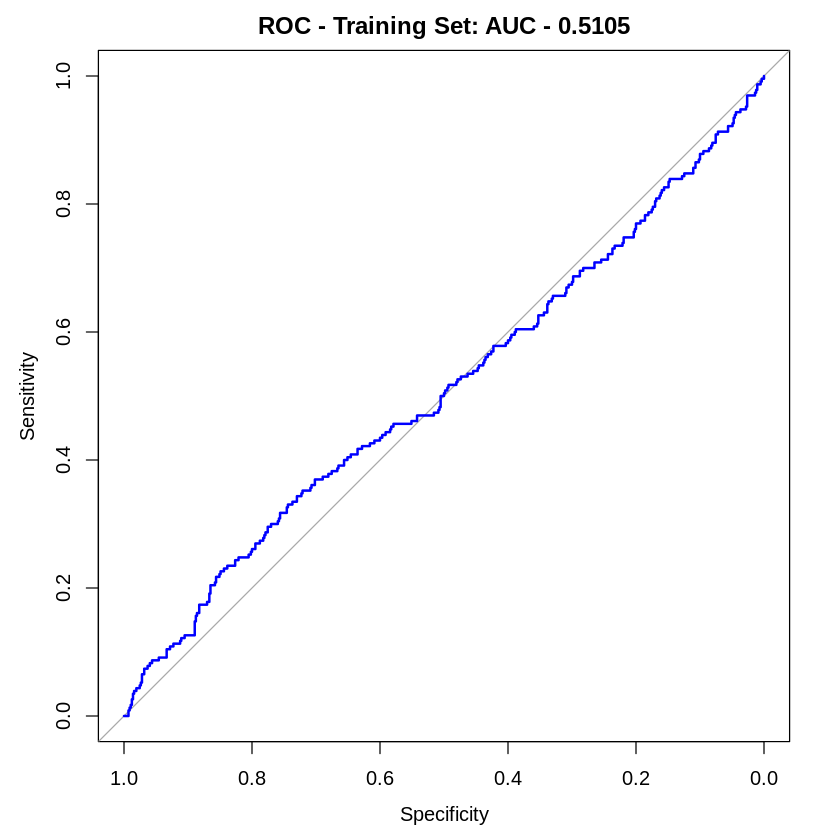

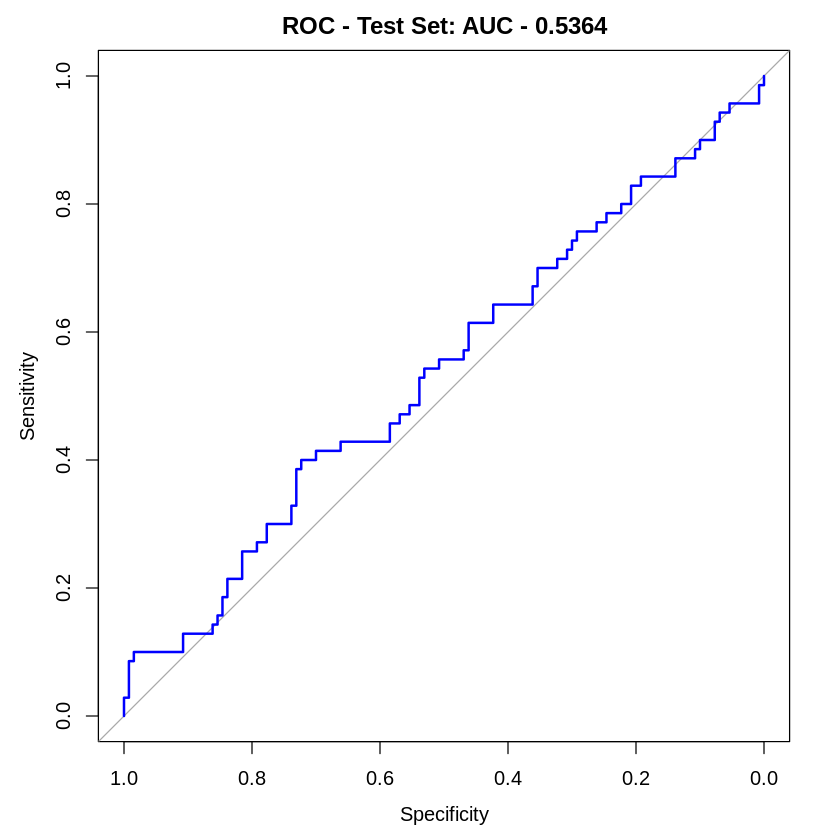

In [ ]:
library(pROC)

# Calculate area under the curve and plot the ROC
train_roc <- roc(y_train, MSE_train2)
plot(train_roc, col = "blue", main = paste0("ROC - Training Set: AUC - ", round(train_roc$auc, 4)))

# Calculate area under the curve and plot the ROC
test_roc <- roc(y_test, MSE_test2)
plot(test_roc, col = "blue", main = paste0("ROC - Test Set: AUC - ", round(test_roc$auc, 4)))

In [ ]:
# run autoencoder on full dataset
minmax_data_frame <- minmax_data_frame %>%
  as.matrix()

pred <- predict(model2, minmax_data_frame)

pred <- as.data.frame(pred)

# join with credit class
credit2 <- cbind(credit$class, pred)

# rename credit$class to class
colnames(credit2)[1] <- c("class")

head(credit2)
dim(credit)
dim(credit2)
     

,class,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,good,-0.6779680,-0.09020964,0.6204249,0.3243661,0.03439176,0.18923149,-0.09774449,0.65706003,-0.2903638,⋯,0.169259563,0.7516112,0.67058009,0.29142907,0.25904530,-0.37415305,0.8273330,-0.2264049,0.37503394,0.7361859
2,bad,-0.5670008,0.24063456,0.1616107,0.1882397,0.02318317,1.09233737,-0.17897120,-0.08356711,-0.4665250,⋯,-0.001401314,0.9303905,0.65461004,-0.28047886,-0.02281116,0.01320308,0.7575179,-0.1568281,0.02026126,0.3115475
3,good,-0.3831669,0.03467154,0.3455489,0.3342057,0.06568156,-0.08476645,0.21040246,0.69766617,-0.1942791,⋯,0.211570352,0.4359602,0.85549819,-0.19073515,0.31232172,0.46678400,0.4476988,-0.1147929,0.37369081,0.2478889
4,good,-0.4639226,0.11140589,0.4175087,0.2192140,0.02600624,0.51927733,0.10336248,0.34790623,-0.3048339,⋯,0.092543833,0.8986212,0.90349770,-0.24295266,0.12252977,0.03039559,0.7757370,-0.1367806,0.19941148,0.4119269
5,bad,-0.4618469,0.01025253,0.5328846,0.2648629,0.05924184,0.21476364,0.10824211,0.48973459,-0.2817230,⋯,0.132059962,0.7485368,0.76726383,0.07791716,0.24775042,0.05454016,0.6327673,-0.1926790,0.27163962,0.5368422
6,good,-0.6557276,0.04856597,0.5212274,0.2468918,0.06595951,0.46024507,-0.19738510,0.26086932,-0.4212961,⋯,0.089766778,0.7011858,0.03719734,0.88757861,0.18674813,0.37403703,0.2790712,-0.2309425,0.06809174,0.4739490


[1] 1000   22

[1] 1000   45

In [ ]:
names(credit2)

[1] "class" "V1"    "V2"    "V3"    "V4"    "V5"    "V6"    "V7"    "V8"   
[10] "V9"    "V10"   "V11"   "V12"   "V13"   "V14"   "V15"   "V16"   "V17"  
[19] "V18"   "V19"   "V20"   "V21"   "V22"   "V23"   "V24"   "V25"   "V26"  
[28] "V27"   "V28"   "V29"   "V30"   "V31"   "V32"   "V33"   "V34"   "V35"  
[37] "V36"   "V37"   "V38"   "V39"   "V40"   "V41"   "V42"   "V43"   "V44"

# New Logistic Regression Model

In [ ]:
# Detach caret package because it causes errors in the below code
detach(package:caret)

# logistic regression evaluated with cross-validation
# include explanatory variables except foreign_worker
# (only 37 of 100 cases are foreign workers)
credit_model2 = "class ~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10 + V11 + 
               V12 + V13 + V14 + V15 + V16 + V17 + V18 + V19 + V20 + V21 + V22 +
               V23 + V24 + V25 + V26 + V27 + V28 + V29 + V30 + V31 + V32 + V33 +
               V34 + V35 + V36 + V37 + V38 + V39 + V40 + V41 + V42 + V43 + V44"

set.seed(1)
nfolds = 5
folds = cvFolds(nrow(credit2), K = nfolds) # creates list of indices

baseprecision = rep(0, nfolds)  # precision with 0 cutoff
baserecall = rep(0, nfolds)  # recall with  0 cutoff
basef1Score = rep(0, nfolds)  # f1Score with 0 cutoff
basecost = rep(0, nfolds)  # total cost with 0 cutoff
ruleprecision = rep(0, nfolds)  # precision with CUTOFF rule
rulerecall = rep(0, nfolds)  # recall with CUTOFF rule
rulef1Score = rep(0, nfolds)  # f1Score with CUTOFF rule
rulecost = rep(0, nfolds)  # total cost with CUTOFF rule

for (ifold in seq(nfolds)) {
    # cat("\n\nSUMMARY FOR IFOLD:", ifold) # checking in development
    # print(summary(credit2[(folds$which == ifold),]))
    # train model on all folds except ifold
    train = credit2[(folds$which != ifold), ]
    test = credit2[(folds$which == ifold),]
    credit_fit = glm(credit_model2, family = binomial,
        data = train)
    # evaluate on fold ifold    
    credit_predict = predict.glm(credit_fit, 
        newdata = test, type = "response")
    baseprecision[ifold] = ppv(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5)
    baserecall[ifold] = recall(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5)
    basef1Score[ifold] = f1Score(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5) 
    basecost[ifold] = sum(
        confusionMatrix(as.numeric(test$class)-1,
        credit_predict) * COSTMATRIX)  
    ruleprecision[ifold] = ppv(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF)  
    rulerecall[ifold] = recall(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF) 
    rulef1Score[ifold] = f1Score(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF)
    rulecost[ifold] = sum(
        confusionMatrix(as.numeric(test$class)-1, 
            credit_predict,cutoff=CUTOFF) * COSTMATRIX)                                    
} 
cvbaseline = data.frame(baseprecision, baserecall, basef1Score, basecost,
    ruleprecision, rulerecall, rulef1Score, rulecost)

cat("\n\nCross-validation summary across folds:\n")
print(round(cvbaseline, digits = 3))
cat("\n\nCross-validation pre-training results under cost cutoff rules:")
cat("\n    F1 Score: ", round(mean(cvbaseline$rulef1Score), digits = 3))
cat("\n    Average cost per fold: ", 
    round(mean(cvbaseline$rulecost), digits = 2), "\n")



Cross-validation summary across folds:
  baseprecision baserecall basef1Score basecost ruleprecision rulerecall
1         0.000      0.000       0.000      311         0.297      0.966
2         0.538      0.115       0.189      276         0.310      1.000
3         0.273      0.105       0.152      271         0.287      0.982
4         0.294      0.085       0.132      282         0.297      0.983
5         0.529      0.141       0.222      283         0.325      1.000
  rulef1Score rulecost
1       0.454      145
2       0.473      136
3       0.444      144
4       0.457      142
5       0.490      133


Cross-validation pre-training results under cost cutoff rules:
    F1 Score:  0.464
    Average cost per fold:  140 
